# Notebook con resultados

## Imports

In [1]:
from seaborn import load_dataset
from sklearn.model_selection import StratifiedKFold
from junifer.storage import HDF5FeatureStorage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nilearn import plotting

In [2]:
from julearn import run_cross_validation
from julearn import PipelineCreator
from julearn.utils import configure_logging
from sklearn.model_selection import StratifiedKFold
from julearn.viz import plot_scores
from junifer.storage import HDF5FeatureStorage
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

## Creación de DataFrames

In [3]:
storage = HDF5FeatureStorage("./test.hdf5")
df_fc = storage.read_df('BOLD_parccortical-TianxS3x3TxMNI6thgeneration')
df_alff = storage.read_df('BOLD_ALFF_parccortical-TianxS3x3TxMNI6thgeneration')
df_participants = pd.read_csv("./participants.tsv", sep="\t")
df_participants.rename(columns={"participant_id": "subject"}, inplace=True)
df_participants.set_index("subject", inplace=True)
parcellation_labels = df_alff.columns.values

In [4]:
df_alff_full = df_alff.merge(df_participants, on="subject")
df_fc_full = df_fc.merge(df_participants, on="subject")

## Conectividad funcional promedio por cada grupo de sujetos

<Figure size 1000x800 with 0 Axes>

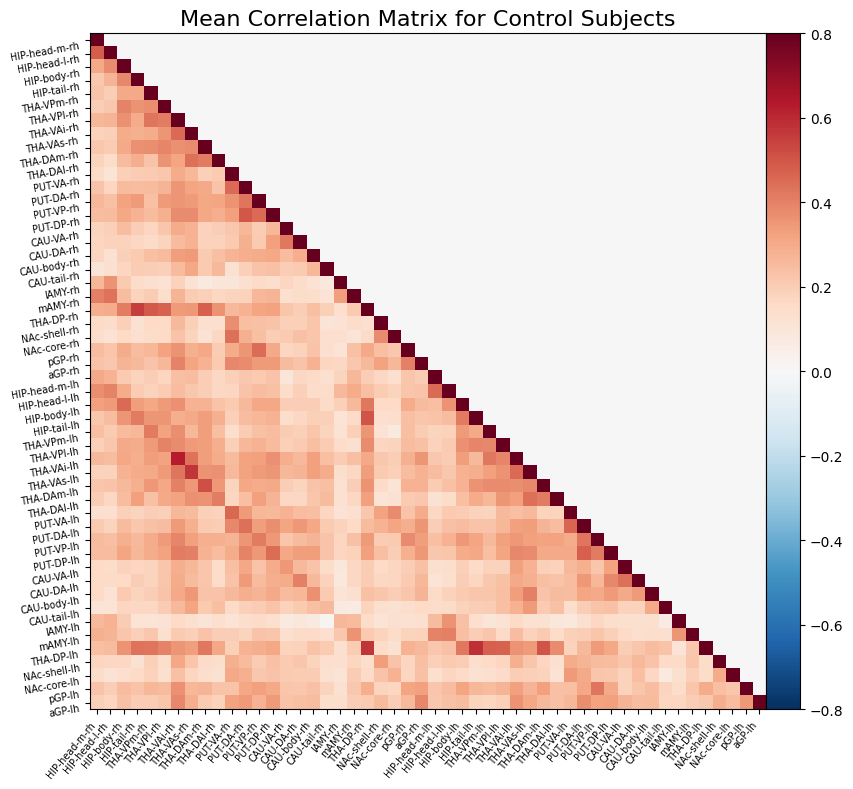

<Figure size 1000x800 with 0 Axes>

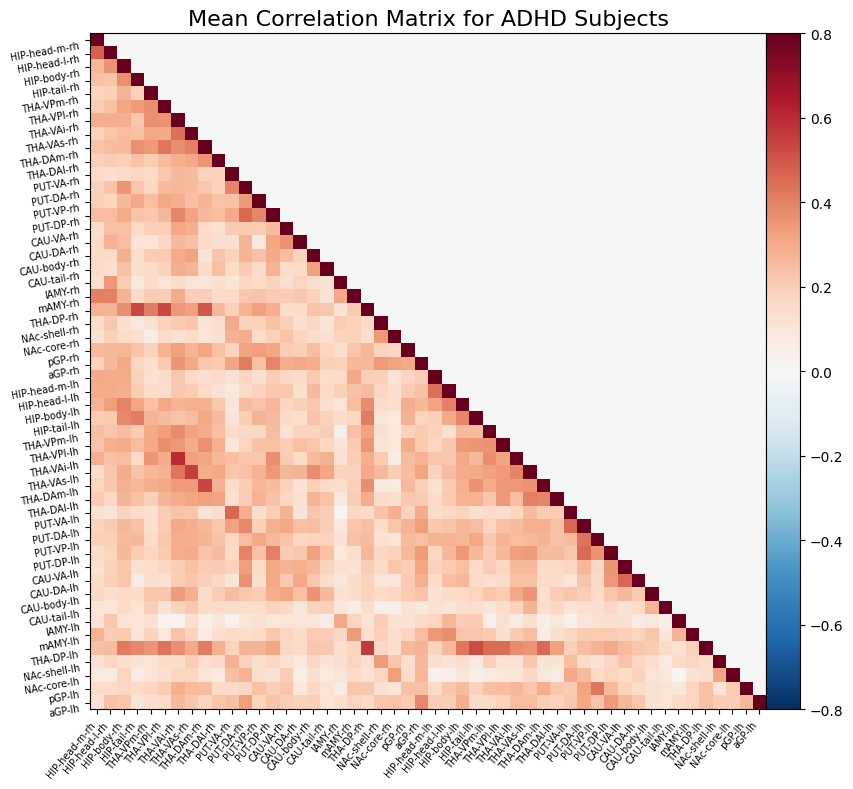

<Figure size 1000x800 with 0 Axes>

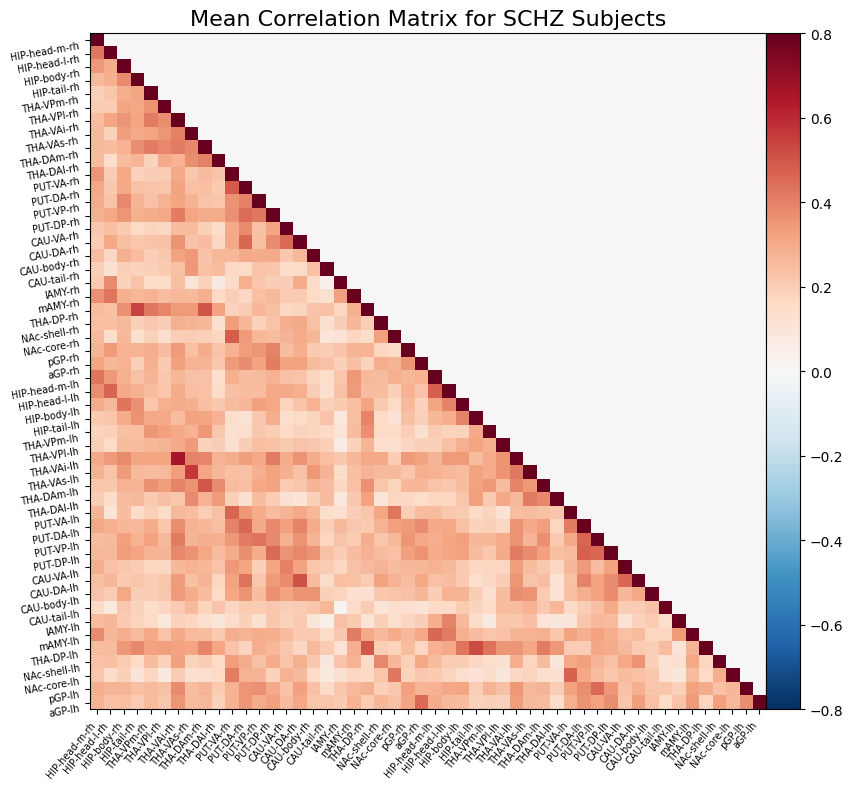

In [5]:
def plot_correlation_matrix(lower_tri_array, parcellation, title="Correlation Matrix"):
    n = int((np.sqrt(1 + 8 * len(lower_tri_array)) - 1) / 2)
    
    corr_matrix = np.zeros((n, n))
    
    tri_indices = np.tril_indices(n)
    corr_matrix[tri_indices] = lower_tri_array

    plt.figure(figsize=(10, 8))
    plotting.plot_matrix(corr_matrix, figure=(10, 8), labels=parcellation, colorbar=True, vmax=0.8, vmin=-0.8, title=title)
    plt.show()

# Get the mean value of the correlation matrix for all subjects with diagnosis AD
lower_mean_control = df_fc_full[df_fc_full['diagnosis'] == 'CONTROL'][df_fc.columns].mean().values
lower_mean_adhd = df_fc_full[df_fc_full['diagnosis'] == 'ADHD'][df_fc.columns].mean().values
lower_mean_schz = df_fc_full[df_fc_full['diagnosis'] == 'SCHZ'][df_fc.columns].mean().values

plot_correlation_matrix(lower_mean_control, parcellation=parcellation_labels, title="Mean Correlation Matrix for Control Subjects")
plot_correlation_matrix(lower_mean_adhd, parcellation=parcellation_labels, title="Mean Correlation Matrix for ADHD Subjects")
plot_correlation_matrix(lower_mean_schz, parcellation=parcellation_labels, title="Mean Correlation Matrix for SCHZ Subjects")


## Exploración con distintos modelos

In [6]:
es_control = lambda x: 1 if x =="CONTROL" else 0
df_fc_full["is_control"] = df_fc_full["diagnosis"].apply(es_control)
df_alff_full["is_control"] = df_alff_full["diagnosis"].apply(es_control)

In [7]:
df_fc_dev, df_fc_test = train_test_split(df_fc_full, test_size=0.2, stratify=df_fc_full["is_control"])
df_alff_dev, df_alff_test = df_alff_full.loc[df_fc_dev.index], df_alff_full.loc[df_fc_test.index]

x_fc_cols, x_alff_cols, target = list(df_fc.columns), list(df_alff.columns),  "is_control" 

### Hacemos PCA para reducir la dimensionalidad de los datos (de ~1200 a 50 columnas)

In [8]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
X_fc_dev = df_fc_dev
pca = PCA(n_components=50)
X_fc_dev_pca = pca.fit_transform(X_fc_dev[x_fc_cols])

In [9]:
df_fc_dev_pca = pd.DataFrame(X_fc_dev_pca, columns = list([str(x) for x in range(X_fc_dev_pca.shape[1])]), index=df_fc_dev.index)
df_fc_dev_pca_cols = list(df_fc_dev_pca.columns)
df_fc_dev_pca[target] = df_fc_dev[target].values

### SVM:
#### Probamos distintas combinaciones de hiperparametros para kernel lineal, rbf y sigmoide para Functional Connectivity

In [10]:
def creator(model_name, hyperparams):
    creator_ = PipelineCreator(problem_type="classification")
    creator_.add("zscore")
    creator_ .add(model_name, **hyperparams)
    return creator_

In [11]:
creator_svm_lin = creator("svm", {"kernel":"linear", "C":np.logspace(-3,3,20)})

In [12]:
def nested_cv(col_names, target_name, data, model):
    scores, model_final, inspector = run_cross_validation(
        X=col_names,
        y=target_name,
        data = data,
        model=model,
        cv=cv,
        return_inspector=True,
        return_train_score=True,
        return_estimator="all",
        search_params={"cv":StratifiedKFold(n_splits=5)},
        scoring = "roc_auc"
    )
    return scores, model_final, inspector

In [13]:
explor_hyperparams_df_fc = pd.DataFrame()

In [14]:
scores_fc_svm_lin, model_svm_fc_lin, inspector_fc_svm_lin = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_svm_lin)

The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']. They will be treated as continuous.
/home/test/miniconda3/envs/neurodc3/lib/python3.11/site-packages/julearn/prepare.py:503: RuntimeWarning: The following columns are not defined in X_types: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']. They will be treated as continuous.
  warn_with_log(


In [18]:
explor_hyperparams_df_fc["svm_lin"] = scores_fc_svm_lin["test_score"]

In [ ]:
creator_svm_rbf = creator("svm", {"kernel":"rbf", "gamma":np.logspace(-3,3,10), "C":np.logspace(-3,3,10)})
scores_fc_svm_rbf, model_svm_fc_rbf, inspector_fc_svm_rbf = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_svm_rbf)

In [20]:
explor_hyperparams_df_fc["svm_rbf"] = scores_fc_svm_rbf["test_score"]

In [ ]:
creator_svm_sigmoid = creator("svm", {"kernel":"sigmoid", "gamma":np.logspace(-3,3,10), "C":np.logspace(-3,3,10)})
scores_fc_svm_sigmoid, model_svm_fc_sigmoid, inspector_fc_svm_sigmoid = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_svm_sigmoid)
explor_hyperparams_df_fc["svm_sigmoid"] = scores_fc_svm_sigmoid["test_score"]

### Random Forests XGBoost

In [ ]:
creator_rf= creator("rf", {"n_estimators":[10,30,70,100,200], "max_depth":[None,5,25,50]})
scores_fc_rf, model_fc_rf, inspector_fc_rf = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_rf)
explor_hyperparams_df_fc["rf"] = scores_fc_rf["test_score"]

In [28]:
from xgboost import XGBClassifier
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 25],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 0.01,1]
}
xgboost = XGBClassifier()

In [ ]:
#creator_xgb = creator(xgboost, xgb_param_grid)
#scores_fc_xgb, model_fc_xgb, inspector_fc_xgb = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_xgb)
#explor_hyperparams_df["xgb"] = scores_fc_xgb["test_score"]

In [ ]:
creator_dummy= creator("dummy", {})
scores_fc_dummy, model_fc_dummy, inspector_fc_dummy = nested_cv(df_fc_dev_pca_cols, target, df_fc_dev_pca, creator_dummy)
explor_hyperparams_df_fc["dummy"] = scores_fc_dummy["test_score"]

### MODELO FINAL FC

In [46]:
import matplotlib.pyplot as plt 
plt.style.use("ggplot")

In [ ]:
explor_hyperparams_df_fc.boxplot()

In [63]:
modelo_final_fc = model_svm_fc_sigmoid.best_estimator_

In [ ]:
df_fc.columns

In [73]:
X_test, y_test = df_fc_test.drop(columns=["is_control"])[df_fc.columns], df_fc_test["is_control"]

In [ ]:
X_test = pca.fit_transform(X_test)
model_fc = modelo_final_fc.train()
model_fc.pred(X_test)


### Random Forest utilizando ALFF

In [73]:
explor_hyperparams_df_alff = pd.DataFrame()

In [ ]:
scores_alff_rf, model_alff_rf, inspector_alff_rf = nested_cv(x_alff_cols, target, df_alff_dev, creator_rf)
explor_hyperparams_df_alff["rf"] = scores_alff_rf["test_score"]

In [ ]:
#creator_rf_alff = PipelineCreator(problem_type="classification")
#creator_rf_alff.add("zscore")
#creator_rf_alff.add("rf", n_estimators=[25,50,100,200], max_depth=[None, 5, 10, 20])

In [ ]:
#scores, model, inspector = run_cross_validation(
#    X= x_alff_cols,
#    y=target,
#    data = df_alff_dev,
#    model=creator_rf_alff,
#    cv=cv,
#    return_train_score=True,
#    return_estimator="all",
#    search_params={"cv":StratifiedKFold(n_splits=5)},
#    return_inspector=True,
#    scoring = "roc_auc"
#)

### SVM:
#### Probamos distintas combinaciones de hiperparametros para kernel lineal, rbf y sigmoide para los datos de ALFF

In [ ]:
scores_alff_svm_lin, model_svm_alff_lin, inspector_alff_svm_lin = nested_cv(x_alff_cols, target, df_alff_dev, creator_svm_lin)

In [74]:
explor_hyperparams_df_alff["svm_lin"] = scores_alff_svm_lin["test_score"]

In [ ]:
scores_alff_svm_rbf, model_svm_alff_rbf, inspector_alff_svm_rbf = nested_cv(x_alff_cols, target, df_alff_dev, creator_svm_rbf)
explor_hyperparams_df_alff["svm_rbf"] = scores_alff_svm_rbf["test_score"]

In [ ]:
scores_alff_svm_sigmoid, model_svm_alff_sigmoid, inspector_alff_svm_sigmoid = nested_cv(x_alff_cols, target, df_alff_dev, creator_svm_sigmoid)
explor_hyperparams_df_alff["svm_sigmoid"] = scores_alff_svm_sigmoid["test_score"]

In [ ]:
scores_alff_dummy, model_alff_dummy, inspector_alff_dummy = nested_cv(x_alff_cols, target, df_alff_dev, creator_dummy)
explor_hyperparams_df_alff["dummy"] = scores_alff_dummy["test_score"]

### MODELO FINAL ALFF

In [ ]:
explor_hyperparams_df_alff.boxplot()

In [ ]:
modelo_final_alff =

In [ ]:
X_test, y_test = df_alff_test.drop(columns=["is_control"])[df_alff.columns], df_alff_test["is_control"]

In [ ]:
model_alff = modelo_final_alff.train()
model_alff.pred(X_test)